In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score
from sklearn.externals import joblib

from imblearn.over_sampling import SMOTE, ADASYN
from scipy import sparse
import xgboost as xgb
from pathlib import Path

import re
from tqdm.auto import tqdm

from wordcloud import WordCloud
import spacy

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tqdm.pandas()
np.random.seed(42)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:748)>


In [2]:
data_path = Path('..')/'data/processed'

In [3]:
def get_data(path):
    df = pd.read_csv(path/'90_day_data_preprossed_no_hospital_deaths.csv')   
    df = df.sample(frac=1).reset_index(drop=True)   
    return df

df = get_data(data_path)
df = df.dropna()

In [4]:
def show_random_note(df):
    idx = np.random.choice(len(df))
    note = df.text.loc[idx]
    print(note)
    return note
    
note = show_random_note(df)

Admission Date:  [**2139-12-7**]       Discharge Date:  [**2139-12-15**]


Service:

HISTORY OF PRESENT ILLNESS:  The patient is an 87-year-old
male who presented to the medical center for evaluation of
recurrent episodes of syncope.  The patient reports the
episodes of syncope began in [**2139-5-27**] and has since then
been worked up an attributed to orthostatic hypotension.  The
patient was started on midodrine for the symptoms.  The
patient reported feeling dizzy before some of the syncopal
episodes, but others were without warning.  The patient has
no history of seizures, strokes, reports ................, no
palpitations and denied having any decrease in fluid intake.
The patient had an exercise stress test on [**2139-11-27**] which
showed moderate reversible defect in the LAD distribution, an
ejection fraction of 67%, borderline ST segment changes.  The
patient reports he is normally very active and does a lot of
walking without dyspnea on exertion.  The patient denied
having an

In [6]:
def process_text(text):
    # convert text to lowercase and strip non-ascii
    text = text.lower()
    text = text.encode("ascii", errors="ignore").decode()
    # get rid of cluttered info in top two lines
    text = re.sub(r'admission date:.*','',text)
    text = re.sub(r'date of birth:.*','',text)
    text = re.sub(r'service:.*','',text)
    # remove extra whitespace and weird ellipses (..,...)
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'[.]{2,}',' ',text)
    # replace numeric chars with <NUM> token
    text = re.sub(r'\d+','<NUM>',text)
    # remove alphanumeric characters only occuring once
    text = re.sub(r'\b\w\b','',text)
    # remove all punctuation except ',<,> and add space before '
    text = re.sub(r"[^\w\s'<>]",' ',text)
    text = re.sub("'"," '",text)
    # remove remaining extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)    
    # remove stop words
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = text.lower()
    return text

# %load_ext line_profiler
# %lprun -f process_text process_text(note)

# %load_ext memory_profiler
# %memit process_text(note)

df['text_processed'] = df.text.progress_apply(lambda x: process_text(x))
df.to_csv(data_path/'90_day_data_postprocessed_no_hospital_deaths.csv',index=False)

In [7]:
df.head(10)

,subject_id,hadm_ids,labels,text,text_processed
0,64925,162022,0,Admission Date: [**2114-1-28**] ...,allergies patient recorded known allergies dru...
1,20873,146145,0,Admission Date: [**2153-2-27**] Discharge...,chief complaint chest pain history present ill...
2,10478,138728,0,Admission Date: [**2146-12-1**] ...,allergies patient recorded known allergies dru...
3,26996,119919 194649,0,Admission Date: [**2128-9-23**] ...,allergies patient recorded known allergies dru...
5,61420,145419,1,Admission Date: [**2197-8-2**] D...,allergies codeine attending first name<num> lf...
6,29129,193390,0,Admission Date: [**2148-5-26**] ...,allergies patient recorded known allergies dru...
7,89294,129168,0,Admission Date: [**2104-12-10**] ...,allergies keflex penicillins attending first n...
8,42217,178390,0,Admission Date: [**2162-1-19**] ...,allergies patient recorded known allergies dru...
9,92057,158444,0,Admission Date: [**2128-4-30**] ...,allergies bactrim attending first name<num> lf...
10,24509,156846,0,Admission Date: [**2140-10-19**] ...,allergies patient recorded known allergies dru...


In [ ]:
def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    #plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

# print('readmit wordcloud')
# pos = df[df['labels']==1].text_processed.sample(n=1000).apply(lambda text: re.sub('NUM','',text))
# show_wordcloud(pos)

# print('non-readmit wordcloud')
# neg = df[df['labels']==0].text_processed.sample(n=1000).apply(lambda text: re.sub('NUM','',text))
# show_wordcloud(neg)

In [44]:
# nlp = spacy.load('en')
# df['text_tokenized'] = df.text_processed.progress_apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))
# df.head()

In [8]:
cv = CountVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words=None,lowercase=False,max_features=30000,max_df=0.9,min_df=1e-4)
X_counts = cv.fit_transform(df.text_processed)
print(X_counts.shape)

(47805, 30000)


In [9]:
tfidf_tr = TfidfTransformer()
X_tfidf = tfidf_tr.fit_transform(X_counts)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, df['labels'], test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [27]:
def get_scores(y_train,yhat_train,y_test,yhat_test):
    print('--Training Set Scores--')
    print('accuracy: ', round(accuracy_score(y_train,yhat_train),4))
    print('precision: ', round(precision_score(y_train,yhat_train),4))
    print('recall: ', round(recall_score(y_train,yhat_train),4))
    print('f1: ', round(f1_score(y_train,yhat_train),4))
    print('auc: ', round(roc_auc_score(y_train,yhat_train),4))
    print('confusion matrix:\n', confusion_matrix(y_train,yhat_train))
    print()
    print('--Test Set Scores--')
    print('accuracy: ', round(accuracy_score(y_test,yhat_test),4))
    print('precision: ', round(precision_score(y_test,yhat_test),4))
    print('recall: ', round(recall_score(y_test,yhat_test),4))
    print('f1: ', round(f1_score(y_test,yhat_test),4))
    print('auc: ', round(roc_auc_score(y_test,yhat_test),4))
    print('confusion matrix:\n', confusion_matrix(y_test,yhat_test))
    
def plot_feature_importances(model,vectorizer,model_type='rf',max_num=10):
    if model_type in ['rf','xgb']:
        importances = model.feature_importances_
    if model_type == 'lr':
        importances = np.abs(model.coef_).flatten()
    
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    
    top_importances = -np.sort(-importances)[:max_num]
    top_importances = np.sort(top_importances)
    
    #std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    
    top_features = np.argsort(-importances)[:max_num]
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()

--Training Set Scores--
accuracy:  0.8482
precision:  0.8923
recall:  0.7919
f1:  0.8391
auc:  0.8482
confusion matrix:
 [[28420  3003]
 [ 6538 24885]]

--Test Set Scores--
accuracy:  0.7956
precision:  0.416
recall:  0.3552
f1:  0.3832
auc:  0.6233
confusion matrix:
 [[7000  852]
 [1102  607]]


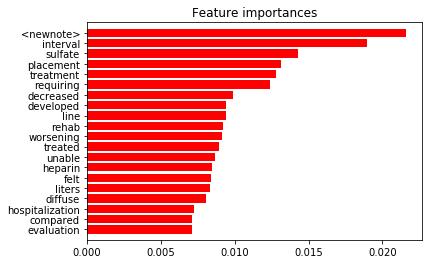

In [28]:
model = RandomForestClassifier(n_estimators=60,min_samples_leaf=50,max_features='auto',min_samples_split=5,n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat_train = model.predict(X_train_bal)
yhat_test = model.predict(X_test)
get_scores(y_train_bal,yhat_train,y_test,yhat_test)

plot_feature_importances(model,cv,model_type='rf',max_num=20)

--Training Set Scores--
accuracy:  0.8107
precision:  0.81
recall:  0.8117
f1:  0.8109
auc:  0.8107
confusion matrix:
 [[25442  5981]
 [ 5917 25506]]

--Test Set Scores--
accuracy:  0.7675
precision:  0.4059
recall:  0.6489
f1:  0.4994
auc:  0.7211
confusion matrix:
 [[6229 1623]
 [ 600 1109]]


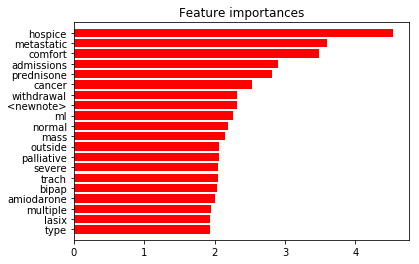

In [26]:
model = LogisticRegression(C=0.3)
model.fit(X_train_bal,y_train_bal)

yhat_train = model.predict(X_train_bal)
yhat_test = model.predict(X_test)
get_scores(y_train_bal,yhat_train,y_test,yhat_test)

plot_feature_importances(model,cv,model_type='lr',max_num=20)

In [77]:
model = xgb.XGBClassifier(n_estimators=100,n_jobs=4)
model.fit(X_train_bal,y_train_bal)

yhat_train = model.predict(X_train_bal)
yhat_test = model.predict(X_test)
get_scores(y_train_bal,yhat_train,y_test,yhat_test)

plot_feature_importances(model,cv,model_type='xgb',max_num=20)

In [ ]:
# # Feature importances
# features = list(X_test.columns)
# importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]
# num_features = len(importances)

# # Plot the feature importances of the tree
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(num_features), importances[indices], yerr=std[indices], 
#         color="g", align="center")
# plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
# plt.xlim([-1, num_features])
# plt.show()